# Set Up

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re

from scipy.stats import skew, chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.impute import SimpleImputer

from wordsegment import load, segment
load()
import nltk
from nltk.corpus import words, brown
# import spacy
from textblob import TextBlob

# nltk.download('words')
# nltk.download('brown')

# Get set of English words
english_words = set(words.words())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [7]:
# Read the main file
main_df = pd.read_csv('dga_data_small.csv')
main_df.head()

,isDGA,domain,host,subclass
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga
2,dga,thenrest,thenrest.net,nivdort
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga


In [8]:
main_df['tld'] = main_df['host'].str.split('.', n=1).str[1]

main_df['cctld'] = main_df['tld'].str.split('.', n=1).str[1].fillna('None') # Code country top level domain

main_df = main_df.rename(columns = {'domain': 'subdomain'})

In [9]:
def is_ascii_domain(subdomain):
    ascii_pattern = re.compile(r'^[a-zA-Z0-9.-]+$')
    return int(bool(ascii_pattern.match(subdomain)))
    
main_df['ascii'] = main_df['subdomain'].apply(is_ascii_domain)

# Domain length
main_df['subdomain_len'] = main_df['subdomain'].str.len()
main_df['host_len'] = main_df['host'].str.len()

In [10]:
main_df

,isDGA,subdomain,host,subclass,tld,cctld,ascii,subdomain_len,host_len
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,13,19
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,26,30
2,dga,thenrest,thenrest.net,nivdort,net,None,1,8,12
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,26,30
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,24,28
...,...,...,...,...,...,...,...,...,...
1995,legit,88ha,88ha.com,alexa,com,None,1,4,8
1996,legit,grooby,grooby.com,alexa,com,None,1,6,10
1997,legit,51zzl,51zzl.com,alexa,com,None,1,5,9
1998,legit,index-education,index-education.com,legit,com,None,1,15,19


In [11]:
# Vowel count
main_df['subdomain_vowel_count'] = main_df['subdomain'].str.lower().str.count(r'[aeoiu]')

# Consonant count
main_df['subdomain_consonant_count'] = main_df['subdomain_len'] - main_df['subdomain_vowel_count']

# Has Numeric - boolean to int type
main_df['has_num'] = main_df['subdomain'].str.contains(r'\d').astype(int)

In [12]:
def legitToNumber(isdga):
    if isdga == 'legit':
        return 1
    else: return 0

main_df['isDGA_N'] = main_df['isDGA'].apply(legitToNumber)

main_df['digitCount'] = main_df['subdomain'].str.count(r'\d')

main_df.head()

,isDGA,subdomain,host,subclass,tld,cctld,ascii,subdomain_len,host_len,subdomain_vowel_count,subdomain_consonant_count,has_num,isDGA_N,digitCount
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,13,19,1,12,0,0,0
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,26,30,4,22,1,0,10
2,dga,thenrest,thenrest.net,nivdort,net,None,1,8,12,2,6,0,0,0
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,26,30,5,21,1,0,7
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,24,28,6,18,1,0,9


In [13]:
OH_encoder = OneHotEncoder(sparse_output=False)

In [14]:
encoded = OH_encoder.fit_transform(np.array(main_df['subclass']).reshape(-1, 1))
encoded_features = pd.DataFrame(encoded, columns=OH_encoder.get_feature_names_out(['subclass']))

main_df = main_df.join(encoded_features)

main_df.head()

,isDGA,subdomain,host,subclass,tld,cctld,ascii,...,subclass_cryptolocker,subclass_gameoverdga,subclass_goz,subclass_legit,subclass_necurs,subclass_newgoz,subclass_nivdort
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,dga,thenrest,thenrest.net,nivdort,net,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for i in main_df.columns:
    if main_df[i].dtype == 'object':
        print(f'Unique values for {i}:', main_df[i].unique())

Unique values for isDGA: ['dga' 'legit']
Unique values for subdomain: ['tyopcrkqgxcfm' '72j5rn1l9mzleo6203v1ogenfl' 'thenrest' ... '51zzl'
 'index-education' 'fastpics']
Unique values for host: ['tyopcrkqgxcfm.co.uk' '72j5rn1l9mzleo6203v1ogenfl.org' 'thenrest.net' ...
 '51zzl.com' 'index-education.com' 'fastpics.us']
Unique values for subclass: ['cryptolocker' 'gameoverdga' 'nivdort' 'necurs' 'newgoz' 'goz' 'bamital'
 'alexa' 'legit']
Unique values for tld: ['co.uk' 'org' 'net' 'ru' 'nf' 'ir' 'biz' 'info' 'bit' 'com' 'bz' 'in'
 'tv' 'kz' 'cx' 'ga' 'ms' 'ki' 'jp' 'sh' 'pro' 'eu' 'la' 'tw' 'mn' 'to'
 'ug' 'xxx' 'us' 'sx' 'ac' 'de' 'im' 'cm' 'co' 'so' 'sc' 'mx' 'su' 'nu'
 'cc' 'com.br' 'io' 'it' 'com.tr' 'be' 'pl' 'gr' 'com.au' 'cl' 'tk'
 'co.id' 'fr' 'nl' 'ch' 'dk' 'hu' 'ua' 'lt' 'gov.tw' 'pe' 'lv' 'com.tw'
 'com.cn' 'ca' 'ba' 'ie' 'ro' 'co.kr' 'vn' 'co.jp' 'pt' 'cn' 'me' 'org.br'
 'at' 'gov.br' 'edu' 'tn' 'blog.br' 'presse.fr' 'net.cn' 'fi' 'am' 'az'
 'ph' 'blogspot.com' 'hr' 'hk' 'is' 

In [16]:
main_df['subclass'].unique().tolist()
# Is it possible to have subclass of legit?

['cryptolocker',
 'gameoverdga',
 'nivdort',
 'necurs',
 'newgoz',
 'goz',
 'bamital',
 'alexa',
 'legit']

<Axes: xlabel='isDGA_N', ylabel='subclass'>

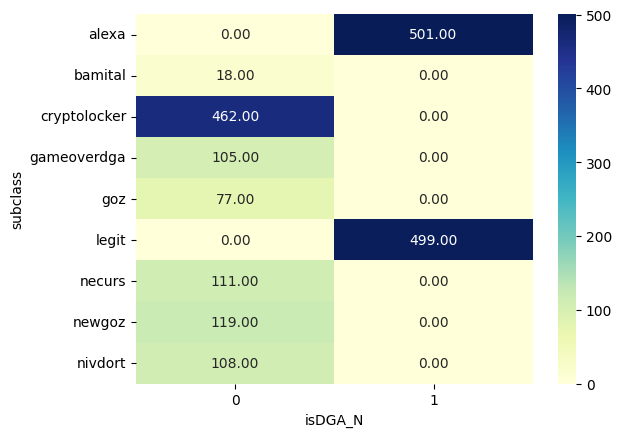

In [17]:
sns.heatmap(pd.crosstab(main_df['subclass'],
                        main_df['isDGA_N']), 
                        annot=True, 
                        fmt='.2f', 
                        cmap='YlGnBu', 
                        cbar=True)

In [18]:
# Check if subdomain starting with digit
main_df['startW/Digit'] = main_df['subdomain'].str.match(r'^\d').astype(int)

# EDA

In [49]:
main_df

,isDGA,subdomain,host,subclass,tld,cctld,ascii,subdomain_len,host_len,subdomain_vowel_count,subdomain_consonant_count,has_num,isDGA_N,digitCount,subclass_alexa,subclass_bamital,subclass_cryptolocker,subclass_gameoverdga,subclass_goz,subclass_legit,subclass_necurs,subclass_newgoz,subclass_nivdort,startW/Digit
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,13,19,1,12,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,26,30,4,22,1,0,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,dga,thenrest,thenrest.net,nivdort,net,None,1,8,12,2,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,26,30,5,21,1,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,24,28,6,18,1,0,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,legit,88ha,88ha.com,alexa,com,None,1,4,8,1,3,1,1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1996,legit,grooby,grooby.com,alexa,com,None,1,6,10,2,4,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1997,legit,51zzl,51zzl.com,alexa,com,None,1,5,9,0,5,1,1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1998,legit,index-education,index-education.com,legit,com,None,1,15,19,7,8,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [20]:
for col in main_df.columns:
    print(f'Unique values for {col}: {main_df[col].unique()}\n')

Unique values for isDGA: ['dga' 'legit']

Unique values for subdomain: ['tyopcrkqgxcfm' '72j5rn1l9mzleo6203v1ogenfl' 'thenrest' ... '51zzl'
 'index-education' 'fastpics']

Unique values for host: ['tyopcrkqgxcfm.co.uk' '72j5rn1l9mzleo6203v1ogenfl.org' 'thenrest.net' ...
 '51zzl.com' 'index-education.com' 'fastpics.us']

Unique values for subclass: ['cryptolocker' 'gameoverdga' 'nivdort' 'necurs' 'newgoz' 'goz' 'bamital'
 'alexa' 'legit']

Unique values for tld: ['co.uk' 'org' 'net' 'ru' 'nf' 'ir' 'biz' 'info' 'bit' 'com' 'bz' 'in'
 'tv' 'kz' 'cx' 'ga' 'ms' 'ki' 'jp' 'sh' 'pro' 'eu' 'la' 'tw' 'mn' 'to'
 'ug' 'xxx' 'us' 'sx' 'ac' 'de' 'im' 'cm' 'co' 'so' 'sc' 'mx' 'su' 'nu'
 'cc' 'com.br' 'io' 'it' 'com.tr' 'be' 'pl' 'gr' 'com.au' 'cl' 'tk'
 'co.id' 'fr' 'nl' 'ch' 'dk' 'hu' 'ua' 'lt' 'gov.tw' 'pe' 'lv' 'com.tw'
 'com.cn' 'ca' 'ba' 'ie' 'ro' 'co.kr' 'vn' 'co.jp' 'pt' 'cn' 'me' 'org.br'
 'at' 'gov.br' 'edu' 'tn' 'blog.br' 'presse.fr' 'net.cn' 'fi' 'am' 'az'
 'ph' 'blogspot.com' 'hr' 'hk' '

In [21]:
legit_df = main_df[(main_df['isDGA']=='legit')].reset_index().drop(columns='index')

legit_df

,isDGA,subdomain,host,subclass,tld,cctld,ascii,...,subclass_gameoverdga,subclass_goz,subclass_legit,subclass_necurs,subclass_newgoz,subclass_nivdort,startW/Digit
0,legit,teacherspayteachers,teacherspayteachers.com,alexa,com,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0
1,legit,animespirit,animespirit.ru,alexa,ru,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0
2,legit,pyramidcollection,pyramidcollection.com,legit,com,None,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0
3,legit,callingcardconnect,callingcardconnect.com,legit,com,None,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0
4,legit,undertonevideo,undertonevideo.com,legit,com,None,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,legit,88ha,88ha.com,alexa,com,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1
996,legit,grooby,grooby.com,alexa,com,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0
997,legit,51zzl,51zzl.com,alexa,com,None,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1
998,legit,index-education,index-education.com,legit,com,None,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0


In [22]:
legit_df['tld'].unique()

array(['com', 'ru', 'com.br', 'io', 'ir', 'net', 'it', 'info', 'com.tr',
       'be', 'org', 'pl', 'gr', 'com.au', 'cl', 'cc', 'tk', 'co.id', 'de',
       'fr', 'nl', 'ch', 'dk', 'hu', 'ua', 'lt', 'jp', 'in', 'co',
       'gov.tw', 'kz', 'co.uk', 'pe', 'lv', 'com.tw', 'com.cn', 'ca',
       'ba', 'ie', 'tv', 'mx', 'xxx', 'ro', 'co.kr', 'vn', 'co.jp', 'pt',
       'cn', 'me', 'org.br', 'at', 'tw', 'eu', 'gov.br', 'edu', 'tn',
       'blog.br', 'presse.fr', 'net.cn', 'fi', 'am', 'az', 'ph', 'nu',
       'blogspot.com', 'hr', 'hk', 'is', 'mu', 'fm', 'us', 'edu.sa',
       'gov', 'no', 'co.il', 'gob.ar', 'com.my', 'com.mx', 'com.ar',
       'asia', 'do', 'cz', 'co.in', 'gouv.fr', 'jus.br', 'se', 'biz'],
      dtype=object)

In [50]:
dga_df = main_df[(main_df['isDGA']!='legit')].reset_index().drop(columns='index')

dga_df

,isDGA,subdomain,host,subclass,tld,cctld,ascii,subdomain_len,host_len,subdomain_vowel_count,subdomain_consonant_count,has_num,isDGA_N,digitCount,subclass_alexa,subclass_bamital,subclass_cryptolocker,subclass_gameoverdga,subclass_goz,subclass_legit,subclass_necurs,subclass_newgoz,subclass_nivdort,startW/Digit
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,13,19,1,12,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,26,30,4,22,1,0,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,dga,thenrest,thenrest.net,nivdort,net,None,1,8,12,2,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,26,30,5,21,1,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,24,28,6,18,1,0,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,dga,jlljsxwrfkys,jlljsxwrfkys.ru,cryptolocker,ru,None,1,12,15,0,12,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
996,dga,maudmjvij,maudmjvij.xxx,necurs,xxx,None,1,9,13,3,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
997,dga,lllndsiljokku,lllndsiljokku.ru,cryptolocker,ru,None,1,13,16,3,10,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
998,dga,septemberfish,septemberfish.net,nivdort,net,None,1,13,17,4,9,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [24]:
legit_df['subdomain_len'].mean()

np.float64(10.021)

In [25]:
dga_df['subdomain_len'].mean()

np.float64(16.998)

# Sample

### Word Segment lib

In [26]:
legit_df_subdomain = legit_df[['subdomain']].copy()

In [27]:
legit_df_subdomain['word_segment'] = legit_df_subdomain['subdomain'].apply(segment)

In [28]:
legit_df_subdomain['word_segment']

0      [teachers, pay, teachers]
1                [anime, spirit]
2          [pyramid, collection]
3       [calling, card, connect]
4             [undertone, video]
                 ...            
995                       [88ha]
996                   [groo, by]
997                      [51zzl]
998           [index, education]
999                 [fast, pics]
Name: word_segment, Length: 1000, dtype: object

In [29]:
def count_true_textblob(list_words):
    valid = []
    for i in list_words:
        if TextBlob(i).correct() == i:
            valid.append(i)

    return valid

def count_true_nltk(list_words):
    valid = []
    for i in list_words:
        if i in english_words:
            valid.append(i)

    return valid

legit_df_subdomain['validation_textblob'] = legit_df_subdomain['word_segment'].apply(count_true_textblob)
legit_df_subdomain['validation_nltk'] = legit_df_subdomain['word_segment'].apply(count_true_nltk)

### Lemmatization

In [30]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatizer_word(lst_text):
    lst_lemm = []
    for word in lst_text:
        if lemmatizer.lemmatize(word) not in lst_lemm:
            lst_lemm.append(lemmatizer.lemmatize(word))

    return lst_lemm


legit_df_subdomain['validation_textblob'] = legit_df_subdomain['validation_textblob'].apply(lemmatizer_word)
legit_df_subdomain['validation_nltk'] = legit_df_subdomain['validation_nltk'].apply(lemmatizer_word)

In [45]:
def get_longer_list(row):
    textblob_len = len(row['validation_textblob'])
    nltk_len = len(row['validation_nltk'])
    return row['validation_textblob'] if textblob_len > nltk_len else row['validation_nltk']

legit_df_subdomain['text_segment_final'] = legit_df_subdomain.apply(get_longer_list, axis = 1)
legit_df_subdomain.drop(columns=['validation_nltk', 'validation_textblob', 'word_segment'], inplace=True)

In [48]:
legit_df_subdomain

,subdomain,word_segment,text_segment_final
0,teacherspayteachers,"[teachers, pay, teachers]","[teacher, pay]"
1,animespirit,"[anime, spirit]","[anime, spirit]"
2,pyramidcollection,"[pyramid, collection]","[pyramid, collection]"
3,callingcardconnect,"[calling, card, connect]","[calling, card, connect]"
4,undertonevideo,"[undertone, video]","[undertone, video]"
...,...,...,...
995,88ha,[88ha],[]
996,grooby,"[groo, by]",[by]
997,51zzl,[51zzl],[51zzl]
998,index-education,"[index, education]","[index, education]"


### Brown

In [32]:
legit_df_subdomain.iloc[291]

subdomain                    taamolnews
word_segment           [taa, mol, news]
validation_textblob              [news]
validation_nltk             [taa, news]
Name: 291, dtype: object

In [33]:
word_freq = nltk.FreqDist(brown.words())

In [34]:
word = "ache"
frequency = word_freq[word.lower()]
print(f"The word '{word}' appears {frequency} times in the Brown corpus.")

The word 'ache' appears 4 times in the Brown corpus.


In [35]:
print(brown.categories())

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


In [36]:
type(brown)

nltk.corpus.reader.tagged.CategorizedTaggedCorpusReader

In [37]:
brown.words(categories='news')

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [38]:
brown.sents()[5]

['It',
 'recommended',
 'that',
 'Fulton',
 'legislators',
 'act',
 '``',
 'to',
 'have',
 'these',
 'laws',
 'studied',
 'and',
 'revised',
 'to',
 'the',
 'end',
 'of',
 'modernizing',
 'and',
 'improving',
 'them',
 "''",
 '.']

In [51]:
main_df.head()

,isDGA,subdomain,host,subclass,tld,cctld,ascii,subdomain_len,host_len,subdomain_vowel_count,subdomain_consonant_count,has_num,isDGA_N,digitCount,subclass_alexa,subclass_bamital,subclass_cryptolocker,subclass_gameoverdga,subclass_goz,subclass_legit,subclass_necurs,subclass_newgoz,subclass_nivdort,startW/Digit
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker,co.uk,uk,1,13,19,1,12,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga,org,None,1,26,30,4,22,1,0,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,dga,thenrest,thenrest.net,nivdort,net,None,1,8,12,2,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga,org,None,1,26,30,5,21,1,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga,net,None,1,24,28,6,18,1,0,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [40]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   isDGA                      2000 non-null   object 
 1   subdomain                  2000 non-null   object 
 2   host                       2000 non-null   object 
 3   subclass                   2000 non-null   object 
 4   tld                        2000 non-null   object 
 5   cctld                      2000 non-null   object 
 6   ascii                      2000 non-null   int64  
 7   subdomain_len              2000 non-null   int64  
 8   host_len                   2000 non-null   int64  
 9   subdomain_vowel_count      2000 non-null   int64  
 10  subdomain_consonant_count  2000 non-null   int64  
 11  has_num                    2000 non-null   int64  
 12  isDGA_N                    2000 non-null   int64  
 13  digitCount                 2000 non-null   int64